# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 25.09.2022

Мягкий дедлайн: 23:59MSK 10.10.2022

Жесткий дедлайн: 23:59MSK 18.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [67]:
!pip install folium

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [70]:
!wget  -O 'train.csv' -q https://www.dropbox.com/s/03ywty7zuao4jqg/train.csv?dl=0

In [71]:
df = pd.read_csv("train.csv")
df.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

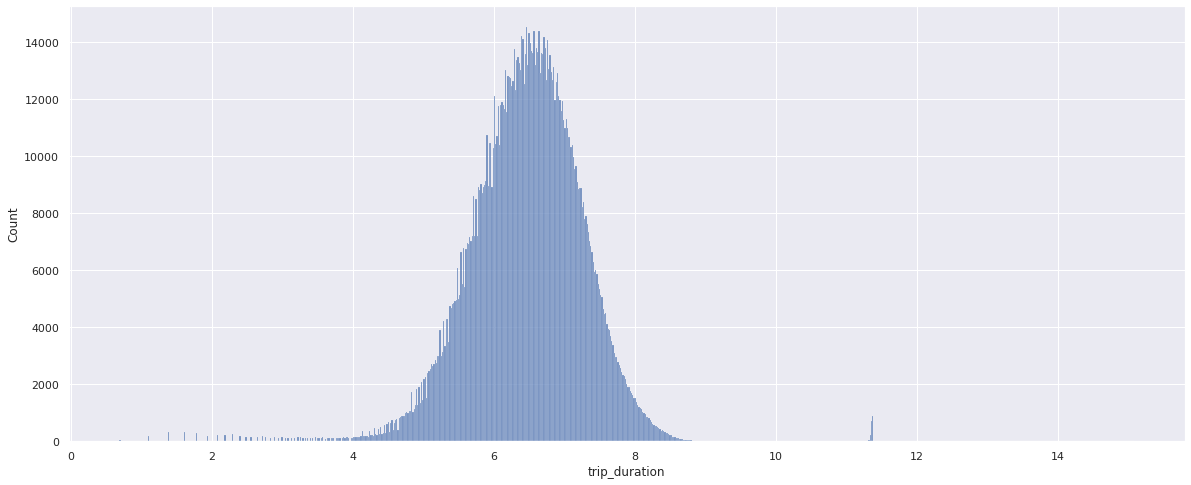

In [72]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.histplot(np.log1p(df['trip_duration']))

Она имеет распределение близкое к нормальному

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Они выбрали RMSLE, потому что длительности поездок находятся в широком диапазоне и мы не хотим считать большие ошибки действительно "большими", если предсказанное значение и реальное сами по себе большие. То есть нам важна ошибка относительно каждого предсказания, а не объективная ее величина. Например для поездки длиной 10 минут ошибка 5 минут большая, а для поездки в 1 час ошибка 5 минут небольшая.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \log({\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - \log({\exp(\hat{a}(x_i)))}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y}_i - {\hat{a}(x_i))}\big)^2} = \sqrt{\text{MSE}(X, \hat{y}, \hat{a})}$$
Минимум корня переменной принимается в тех же значениях что и минимум переменной, поэтому эти оптимизации эквивалентны.



Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [73]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [74]:
from sklearn.metrics import mean_squared_error
y_pred = df['log_trip_duration']
y_true = [y_pred.mean()] * y_pred.shape[0]
print("MSE:")
mean_squared_error(y_true, y_pred, squared=False)

MSE:


0.7957592365411509

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [75]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y%m%d %H:%M:%S.%f')

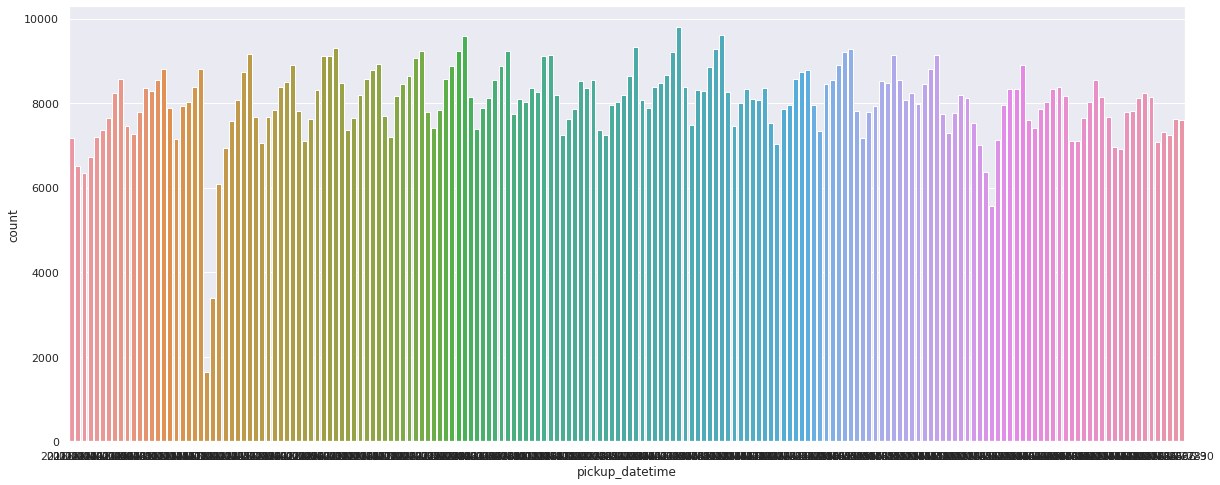

In [76]:
sns.countplot(x=df["pickup_datetime"].dt.date.sort_values())

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

In [77]:
df['pickup_datetime'].dt.date.value_counts().sort_values()[:10].sort_index()

2016-01-02    6512
2016-01-03    6353
2016-01-04    6725
2016-01-23    1648
2016-01-24    3383
2016-01-25    6084
2016-01-26    6941
2016-05-29    6372
2016-05-30    5570
2016-06-20    6910
Name: pickup_datetime, dtype: int64

23-25 января - самый сильный снегопад за столетие в Нью Йорке и его последствия \\
29-30 мая аномальная жара

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [78]:
order_by_hour = np.array(df['pickup_datetime'].dt.hour.value_counts().sort_index())
order_by_weekday = np.array(df['pickup_datetime'].dt.weekday.value_counts().sort_index())

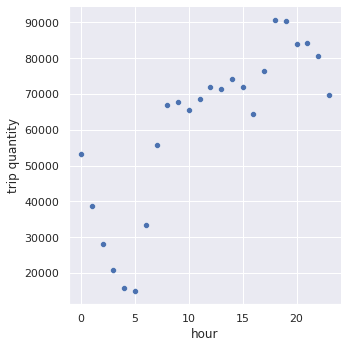

In [79]:
sns.relplot(x=list(range(0, 24)), y=order_by_hour).set(xlabel='hour', ylabel='trip quantity')

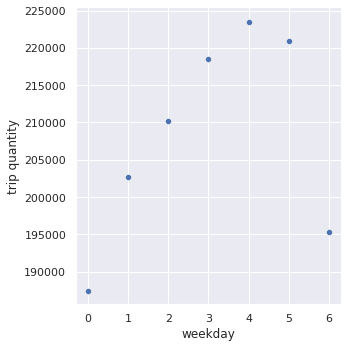

In [80]:
sns.relplot(x=list(range(0, 7)), y=order_by_weekday).set(xlabel='weekday', ylabel='trip quantity')

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [81]:
df['month'] = df['pickup_datetime'].dt.month
df['hour'] = df['pickup_datetime'].dt.hour

In [82]:
gk = df.groupby(['month', 'hour'])
gk = gk.agg('size').reset_index().rename(columns={0: 'quantity'})

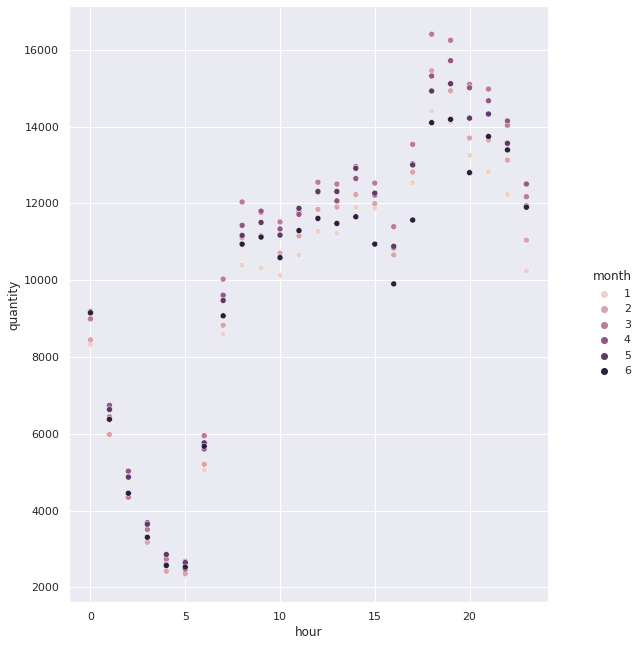

In [83]:
sns.relplot(data=gk, x='hour', y='quantity', hue='month').figure.set_size_inches(10, 10)

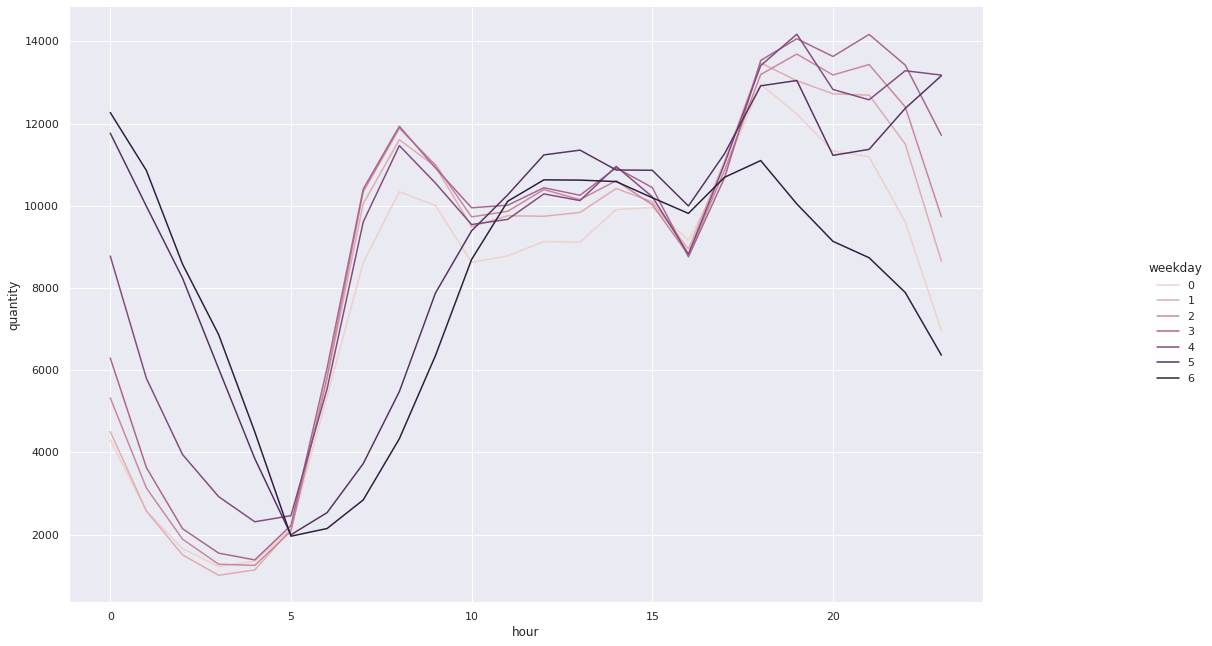

In [84]:
df['weekday'] = df['pickup_datetime'].dt.weekday
gk = df.groupby(['weekday', 'hour'])
gk = gk.agg('size').reset_index().rename(columns={0: 'quantity'})
sns.relplot(data=gk, x='hour', y='quantity', hue='weekday', kind='line').figure.set_size_inches(20, 10)

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

С 3 до 6 утра поездок мало в любые месяцы. В теплое время года больше ночных (2-5 утра) заказов, чем обычно (у многих отпуск или каникулы)
По субботам и воскресеньям ночных заказов очень много (ночная жизнь Нью-Йорка), в будние дни мало и чем ближе к выходным, тем их больше. 
В воскресенье вечером мало вечерних заказов, так как следующий день рабочий

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3. По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [85]:
from sklearn.model_selection import train_test_split
y = df["log_trip_duration"]
X = df.drop(columns=["log_trip_duration"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [86]:
df['date'] = df['pickup_datetime'].dt.date
gk_by_weekday = df[df['id'].isin(X_test['id'])].groupby('weekday', as_index=False)['log_trip_duration'].mean()
gk_by_hour = df[df['id'].isin(X_test['id'])].groupby('hour', as_index=False)['log_trip_duration'].mean()
gk_by_date = df[df['id'].isin(X_test['id'])].groupby('date', as_index=False)['log_trip_duration'].mean()

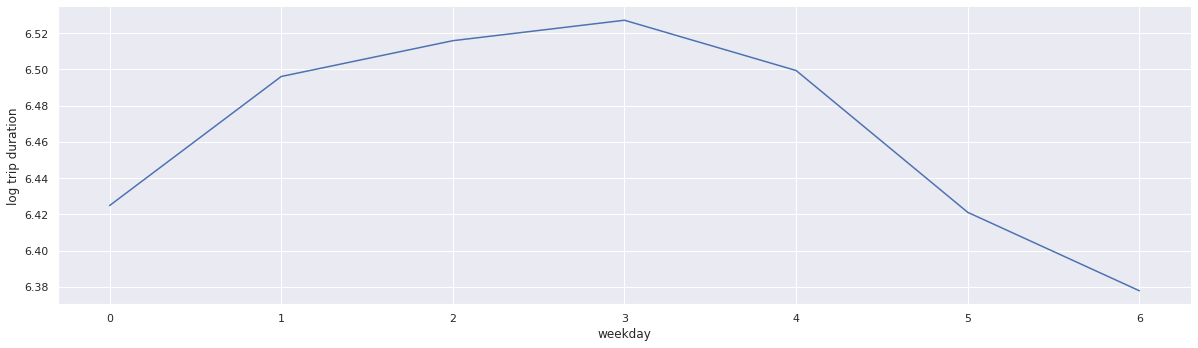

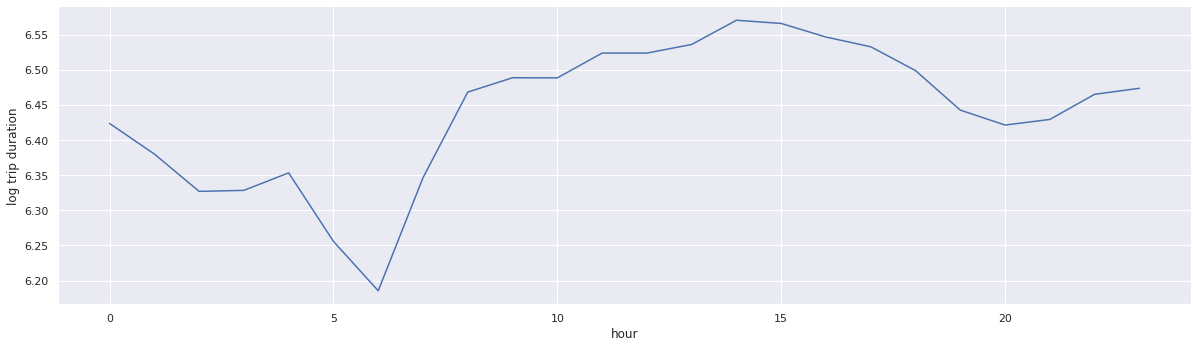

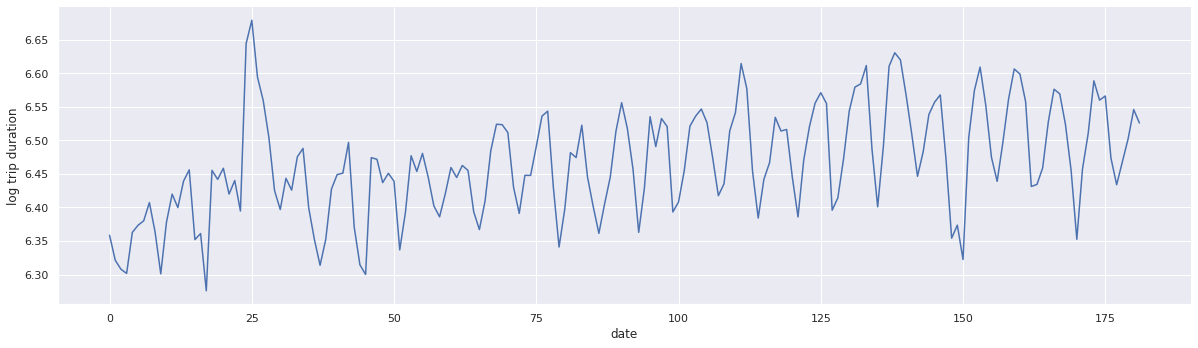

In [87]:
sns.relplot(x=list(range(gk_by_weekday.shape[0])), y=gk_by_weekday['log_trip_duration'], kind='line').set(xlabel='weekday', ylabel='log trip duration').figure.set_size_inches(20, 5)
sns.relplot(x=list(range(gk_by_hour.shape[0])), y=gk_by_hour['log_trip_duration'], kind='line').set(xlabel='hour', ylabel='log trip duration').figure.set_size_inches(20, 5)
sns.relplot(x=list(range(gk_by_date.shape[0])), y=gk_by_date['log_trip_duration'], kind='line').set(xlabel='date', ylabel='log trip duration').figure.set_size_inches(20, 5)

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок похожи.
В день снегопада длительность поездки была самая высокая, поэтому 23-24 января таргет резко возрастает. 29-30 мая была жара, поэтому видимо никто никуда далеко не ездил и средняя продолжительность поездки упала. В зависимости от дня в году длительность то растет, то падает, скорее всего из-за дней недели, когда самые сильные пробки


Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [88]:
# остальные уже добавил выше
df['number_of_day'] = df['pickup_datetime'].dt.dayofyear
df['is_blizzard'] = (23 <= df['pickup_datetime'].dt.dayofyear) & (df['pickup_datetime'].dt.dayofyear <= 25)
df['is_heat'] = (150 <= df['pickup_datetime'].dt.dayofyear) & (df['pickup_datetime'].dt.dayofyear <= 151)

In [89]:
df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'month', 'hour', 'weekday',
       'date', 'number_of_day', 'is_blizzard', 'is_heat'],
      dtype='object')

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков стоит рассматривать как категориальные, а какие - как численные? Почему?

store_and_fwd_flag, is_blizzard, is_heat - категориальные \\
number_of_day, weekday, hour, month, длительность поездок, координаты и тд - численные

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [90]:
# еще раз проведем разбиение, так как добавили новые признаки
y = df["log_trip_duration"]
X = df.drop(columns=['log_trip_duration', 'id', 'vendor_id', 'trip_duration'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [91]:
categorical = ['weekday', 'hour', 'month', 'number_of_day']
numeric_features = ['is_blizzard', 'is_heat']

In [92]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Test RMSE = 0.7871
Test MSE = 0.6196


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [93]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [94]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [95]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие две точки выделяются на карте?

Аэропорты

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [96]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [97]:
df['haversine'] = haversine_array(df['pickup_latitude'], df['pickup_longitude'], df['dropoff_latitude'], df['dropoff_longitude'])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку:

In [98]:
df['log_haversine'] = np.log1p(df['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

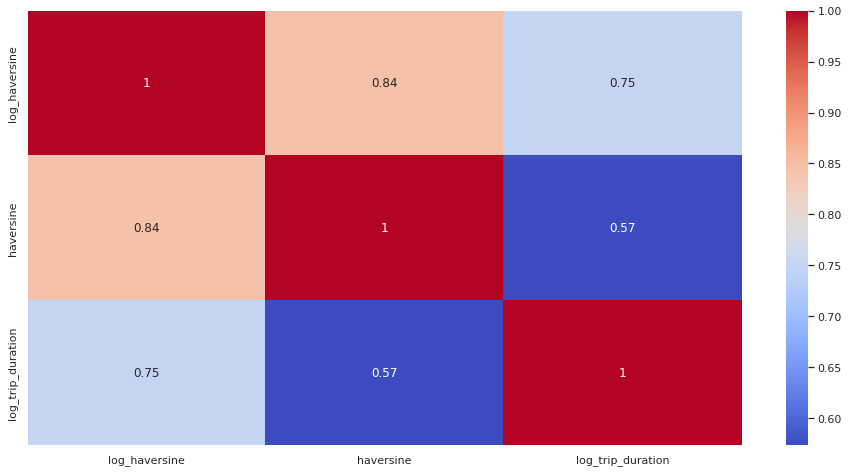

In [99]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(df[['log_haversine', 'haversine', 'log_trip_duration']].corr(), annot=True, fmt='.2g', cmap='coolwarm')

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

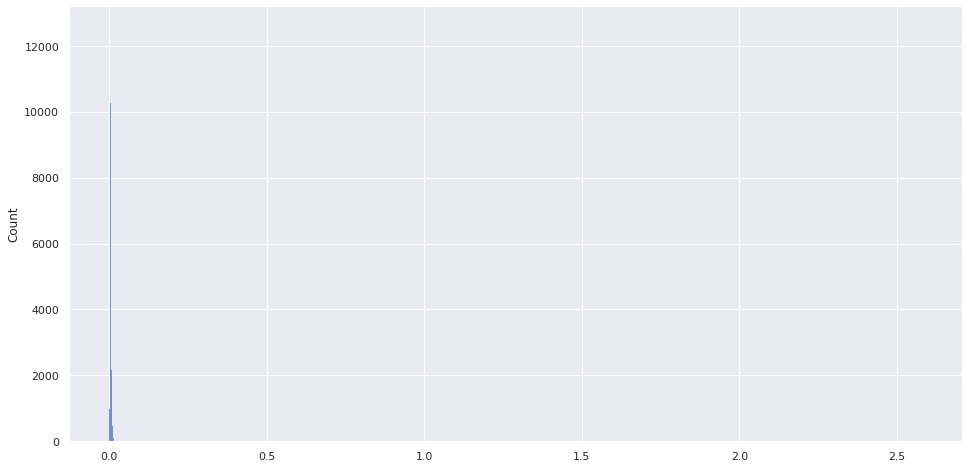

In [100]:
y = df["log_trip_duration"]
X = df
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
sns.histplot(X_train['haversine'] / X_train['trip_duration'])

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

In [101]:
speeds = X_train['haversine'] / X_train['trip_duration']
speed_quantile = np.quantile(speeds, 0.95)
X_train['velocity'] = speeds

In [102]:
X_train_clipped = X_train[X_train['velocity'] < speed_quantile]

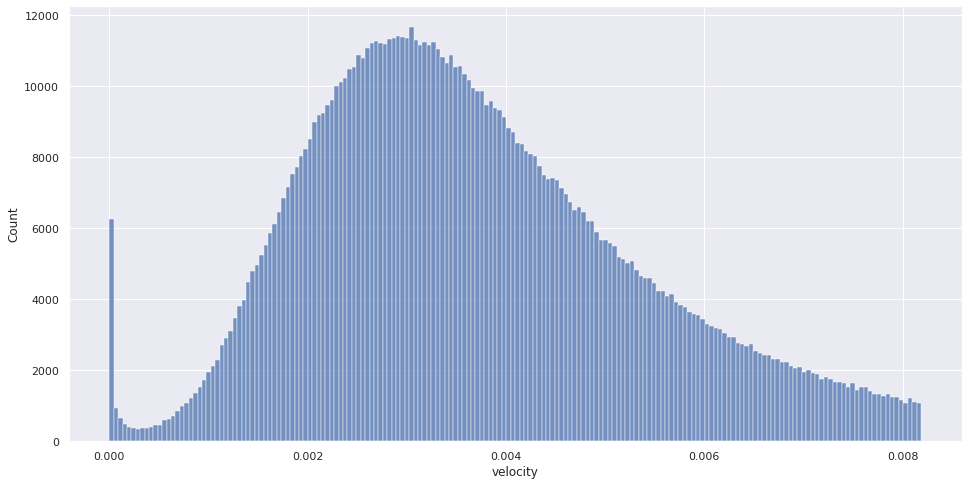

In [103]:
sns.histplot(X_train_clipped['velocity'])

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [104]:
gk = X_train.groupby(['weekday', 'hour'])['velocity'].agg('median').reset_index().rename(columns={'velocity': 'median_velocity'})

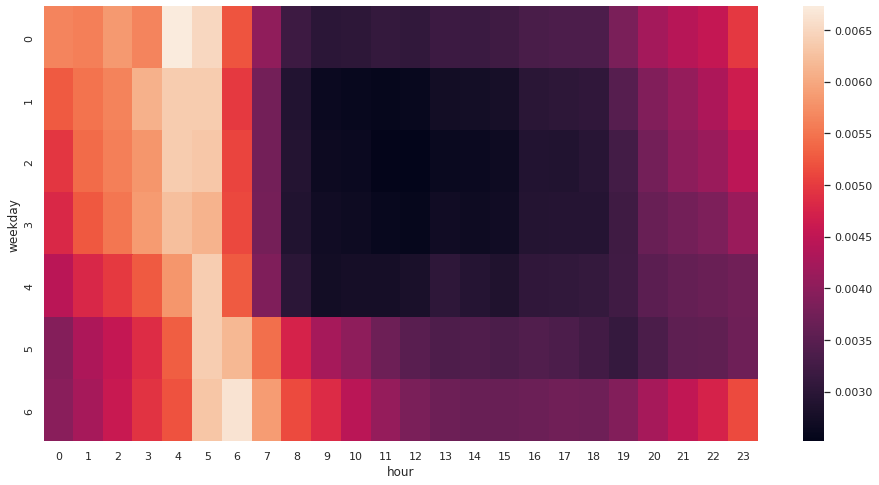

In [105]:
gk = gk.pivot('weekday', 'hour', 'median_velocity')
sns.heatmap(gk)

In [106]:
X_train.drop(columns=['velocity'], inplace=True)

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

Потому что ее нельзя вычислить без знания времени поездки, а мы ее и должны угадать

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

По будням и выхоодным часы пик разные, берем их

In [107]:
cond = (((0 <= df['weekday']) & (df['weekday'] <= 4) & (8 <= df['hour']) & (df['hour'] <= 19)) | ((5 <= df['weekday']) & (df['weekday'] <= 6) & (13 <= df['hour']) & (df['hour'] <= 18)))
df.loc[cond, 'is_jam'] = 1
df.loc[~cond, 'is_jam'] = 0
# X_train.loc[~cond, 'is_free'] = 1
# X_train.loc[cond, 'is_free'] = 0

**Задание 8 (0.25 балла)**. Как уже было замечено выше, на карте выделяются две точки вдали от Манхэттена. Для каждой из них добавьте в выборку два признака: началась ли поездка в ней и закончилась ли она в ней.

In [108]:
aeroports = [(40.77283645898613, -73.86911646590806, 900), (40.64578147061409, -73.7849524537164, 1000)]

def get_circle(lat, longt, radius, label):
  return haversine_array(df[f'{label}_latitude'], df[f'{label}_longitude'], lat, longt) <= radius

df['pickup_at_lga'] = 0
df.loc[get_circle(aeroports[0][0], aeroports[0][1], 0.9, 'pickup'), 'pickup_at_lga'] = 1
df['pickup_at_jfk'] = 0
df.loc[get_circle(aeroports[1][0], aeroports[1][1], 1, 'pickup'), 'pickup_at_jfk'] = 1

df['dropoff_at_lga'] = 0
df.loc[get_circle(aeroports[0][0], aeroports[0][1], 0.9, 'dropoff'), 'dropoff_at_lga'] = 1
df['dropoff_at_jfk'] = 0
df.loc[get_circle(aeroports[1][0], aeroports[1][1], 1, 'dropoff'), 'dropoff_at_jfk'] = 1


center_location = (df['pickup_latitude'].mean(), df['pickup_longitude'].mean())
m = folium.Map(location=center_location, zoom_start=12)
for dot in aeroports:
  folium.Circle(
                radius=dot[2],
                location=(dot[0], dot[1]),
                color='orange',
                fill_color='orange',
                fill=True
            ).add_to(m)
m

In [109]:
# проверим что верно находим точки вокруг аэропортов
m = folium.Map(location=center_location, zoom_start=12)
for _, row in df[get_circle(aeroports[0][0], aeroports[0][1], 0.9, 'pickup')].sample(1000).iterrows():
        folium.Circle(
            radius=10,
            location=(row['pickup_latitude'], row['pickup_longitude']),
            color='orange',
            fill_color='orange',
            fill=True
        ).add_to(m)
for _, row in df[get_circle(aeroports[1][0], aeroports[1][1], 1, 'pickup')].sample(1000).iterrows():
        folium.Circle(
            radius=10,
            location=(row['pickup_latitude'], row['pickup_longitude']),
            color='orange',
            fill_color='orange',
            fill=True
        ).add_to(m)
m

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

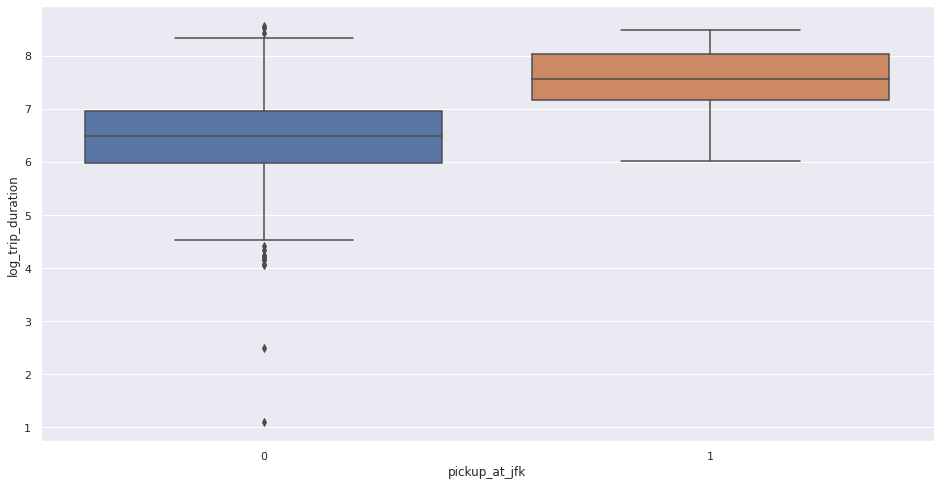

In [110]:
sns.boxplot(data=df.sample(1000), x='pickup_at_jfk', y='log_trip_duration')

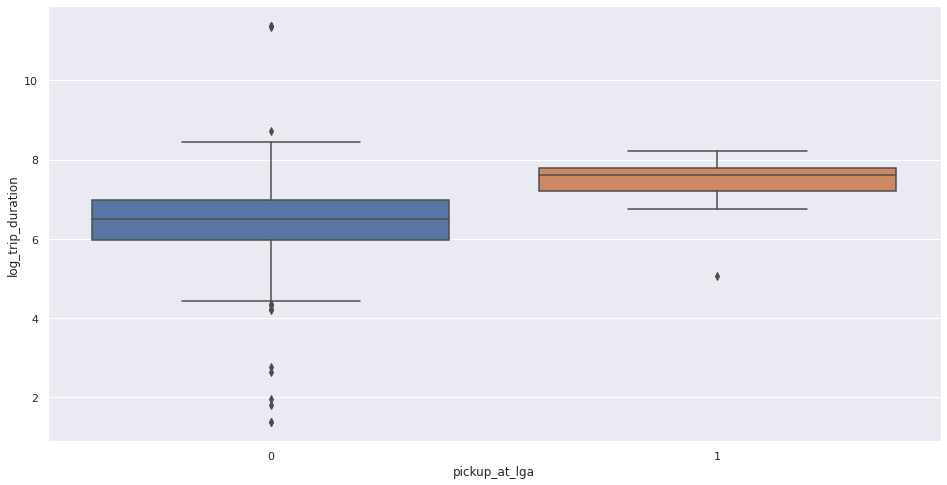

In [111]:
sns.boxplot(data=df.sample(1000), x='pickup_at_lga', y='log_trip_duration')

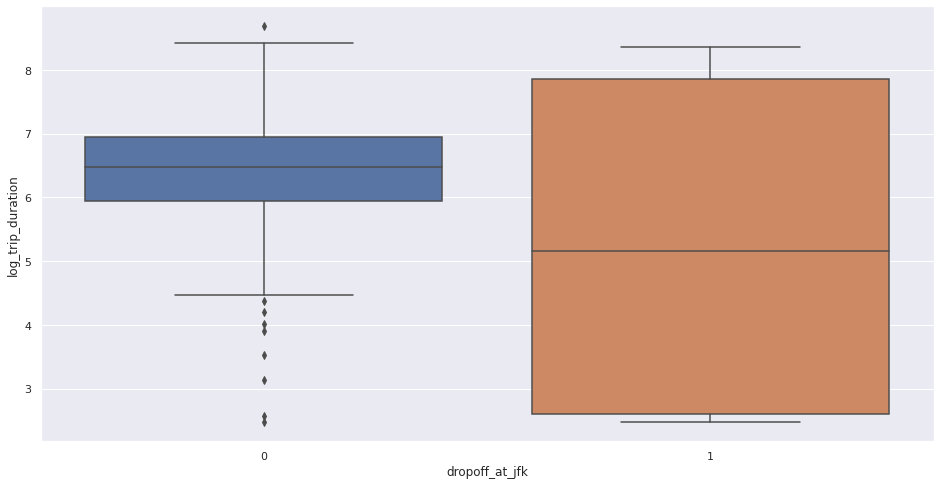

In [112]:
sns.boxplot(data=df.sample(1000), x='dropoff_at_jfk', y='log_trip_duration')

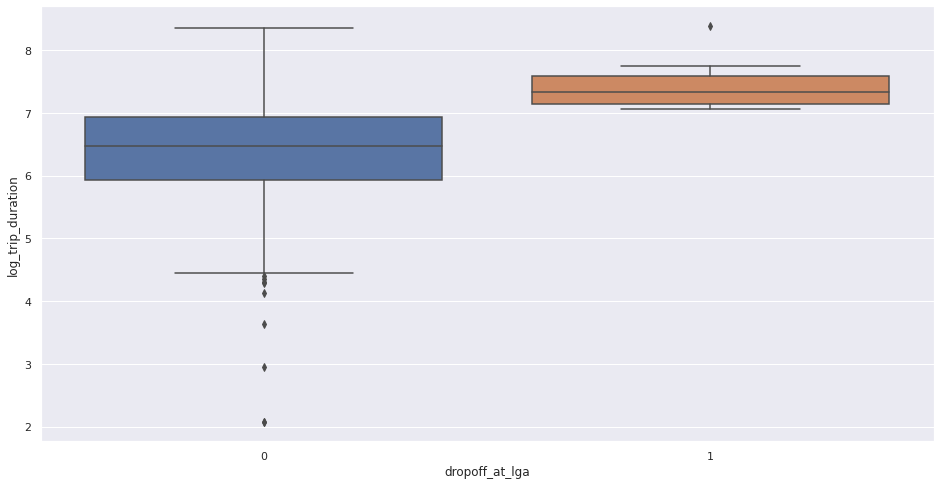

In [113]:
sns.boxplot(data=df.sample(1000), x='dropoff_at_lga', y='log_trip_duration')

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Да, прослеживается зависимость от них времени в поездке

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [114]:
# нашел точки по гугл картам
center_location = (df['pickup_latitude'].mean(), df['pickup_longitude'].mean())
m = folium.Map(location=center_location, zoom_start=12)
upper_right = (40.796345214160446, -73.938309426549)
down_left = (40.70676259495365, -74.01981135236582)
def get_rectangle(down_left, upper_right, label, df):
  return ((df[f'{label}_latitude'] <= upper_right[0]) & (df[f'{label}_latitude'] >= down_left[0]) & (df[f'{label}_longitude'] <= upper_right[1]) & (df[f'{label}_longitude'] >= down_left[1]))

# get rectangles
rectangles_coord = []
rect_height = (upper_right[0] - down_left[0]) / 4
rect_width = (upper_right[1] - down_left[1]) / 3
for longt in range(3):
  for lat in range(4):
    up_r = (down_left[0] + (lat + 1) * rect_height, down_left[1] + (longt + 1) * rect_width)
    down_l = (down_left[0] + lat * rect_height, down_left[1] + longt * rect_width)
    rectangles_coord.append((down_l, up_r))
    folium.Rectangle(
          [down_l, up_r],
          weight=2,
          fill_color="green",
          fill_opacity=0.4).add_to(m)

# dots
def print_dots(df):
  for _, row in df.iterrows():
        folium.Circle(
            radius=10,
            location=(row['pickup_latitude'], row['pickup_longitude']),
            color='blue',
            fill_color='blue',
            fill=True
        ).add_to(m)

print_dots(X_train[get_rectangle(down_left, upper_right, 'pickup', X_train)].sample(500))

In [115]:
m

In [116]:
from sklearn.base import BaseEstimator, TransformerMixin

# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently
    
class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, rectangles_coord):
        self.rectangles_coord = rectangles_coord
        pass
    
    def show_map(self, X):
        colors_by_zone = ['#2499ff', '#00856f', '#5d3954', '#905d5d', '#cac4b0', '#ebc2af', '#c35831', '#217074', '#9d81ba', '#3b5998', '#006633', '#00ffa6', '#1e1112']
        m = folium.Map(location=center_location, zoom_start=12)

        for dot in rectangles_coord:
          folium.Rectangle(
            [dot[0], dot[1]],
            weight=2,
            fill_color="green",
            fill_opacity=0.4).add_to(m)
        for _, row in X.iterrows():
          folium.Circle(
              radius=10,
              location=(row['pickup_latitude'], row['pickup_longitude']),
              color=colors_by_zone[row['pickup_city_zone'] + 1],
              fill_color=colors_by_zone[row['pickup_city_zone'] + 1],
              fill=True
          ).add_to(m)
        return m
    
    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['pickup_city_zone'] = -1
        X['dropoff_city_zone'] = -1
        for zone, dot in enumerate(self.rectangles_coord):
          X.loc[get_rectangle(dot[0], dot[1], 'pickup', X), 'pickup_city_zone'] = zone
          X.loc[get_rectangle(dot[0], dot[1], 'dropoff', X), 'dropoff_city_zone'] = zone
        return X

In [117]:
map_transformer = MapGridTransformer(rectangles_coord)
df = map_transformer.transform(df)

In [118]:
map_transformer.show_map(df.sample(2000))

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [119]:
df

id  vendor_id     pickup_datetime     dropoff_datetime  \
0        id2875421          2 2016-03-14 17:24:55  2016-03-14 17:32:30   
1        id2377394          1 2016-06-12 00:43:35  2016-06-12 00:54:38   
2        id3858529          2 2016-01-19 11:35:24  2016-01-19 12:10:48   
3        id3504673          2 2016-04-06 19:32:31  2016-04-06 19:39:40   
4        id2181028          2 2016-03-26 13:30:55  2016-03-26 13:38:10   
...            ...        ...                 ...                  ...   
1458639  id2376096          2 2016-04-08 13:31:04  2016-04-08 13:44:02   
1458640  id1049543          1 2016-01-10 07:35:15  2016-01-10 07:46:10   
1458641  id2304944          2 2016-04-22 06:57:41  2016-04-22 07:10:25   
1458642  id2714485          1 2016-01-05 15:56:26  2016-01-05 16:02:39   
1458643  id1209952          1 2016-04-05 14:44:25  2016-04-05 14:47:43   

         passenger_count  pickup_longitude  pickup_latitude  \
0                      1        -73.982155        40.767937   
1                      1        -73.980415        40.738564   
2                      1        -73.979027        40.763939   
3                      1        -74.010040        40.719971   
4                      1        -73.973053        40.793209   
...                  ...               ...              ...   
1458639                4        -73.982201        40.745522   
1458640                1        -74.000946        40.747379   
1458641                1        -73.959129        40.768799   
1458642                1        -73.982079        40.749062   
1458643                1        -73.979538        40.781750   

         dropoff_longitude  dropoff_latitude store_and_fwd_flag  ...  is_heat  \
0               -73.964630         40.765602                  N  ...    False   
1               -73.999481         40.731152                  N  ...    False   
2               -74.005333         40.710087                  N  ...    False   
3               -74.012268         40.706718                  N  ...    False   
4               -73.972923         40.782520                  N  ...    False   
...                    ...               ...                ...  ...      ...   
1458639         -73.994911         40.740170                  N  ...    False   
1458640         -73.970184         40.796547                  N  ...    False   
1458641         -74.004433         40.707371                  N  ...    False   
1458642         -73.974632         40.757107                  N  ...    False   
1458643         -73.972809         40.790585                  N  ...    False   

         haversine  log_haversine  is_jam  pickup_at_lga pickup_at_jfk  \
0         1.498521       0.915699     1.0              0             0   
1         1.805507       1.031584     0.0              0             0   
2         6.385098       1.999464     1.0              0             0   
3         1.485498       0.910473     1.0              0             0   
4         1.188588       0.783257     1.0              0             0   
...            ...            ...     ...            ...           ...   
1458639   1.225080       0.799793     1.0              0             0   
1458640   6.049836       1.953004     0.0              0             0   
1458641   7.824606       2.177544     0.0              0             0   
1458642   1.092564       0.738390     1.0              0             0   
1458643   1.134042       0.758018     1.0              0             0   

         dropoff_at_lga  dropoff_at_jfk  pickup_city_zone  dropoff_city_zone  
0                     0               0                 6                 10  
1                     0               0                 5                  1  
2                     0               0                 6                  0  
3                     0               0                 0                 -1  
4                     0               0                 7                  7  
...                 ...           

In [120]:
categorical = ['weekday', 'hour', 'month', 'number_of_day', 'pickup_city_zone', 'dropoff_city_zone', 'is_jam', 'is_blizzard', 'is_heat', 'pickup_at_jfk', 'dropoff_at_jfk', 'dropoff_at_lga', 'pickup_at_lga']
numeric_features = ['log_haversine']

X_train, X_test, y_train, y_test = train_test_split(df, df['log_trip_duration'], test_size=0.3, random_state=10)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)

In [121]:
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4725


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

Бренд перевозчика может влиять на род заказов и соответственно их длительность. Количестве пассажиров влияет на количество точек высадки, то есть тоже увеличивает продолжительность поездки. store_and_fwd_flag может потенциально обозначать выбросы по времени (так как продолжительность поездки может менятьтся из за отложенноой оттправки на сервер)

In [122]:
len(df['vendor_id'].value_counts())

2

In [123]:
len(df['passenger_count'].value_counts())

10

In [124]:
len(df['store_and_fwd_flag'].value_counts())

2

Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

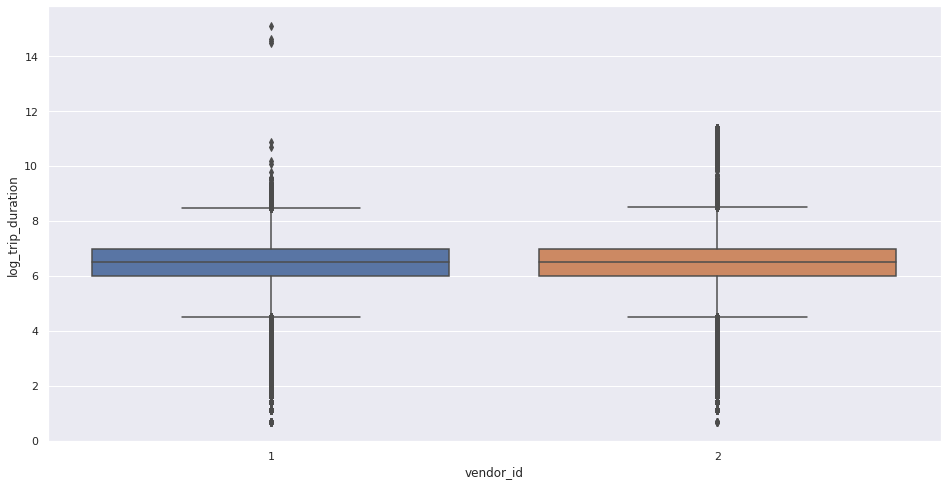

In [125]:
sns.boxplot(data=df, x='vendor_id', y='log_trip_duration')

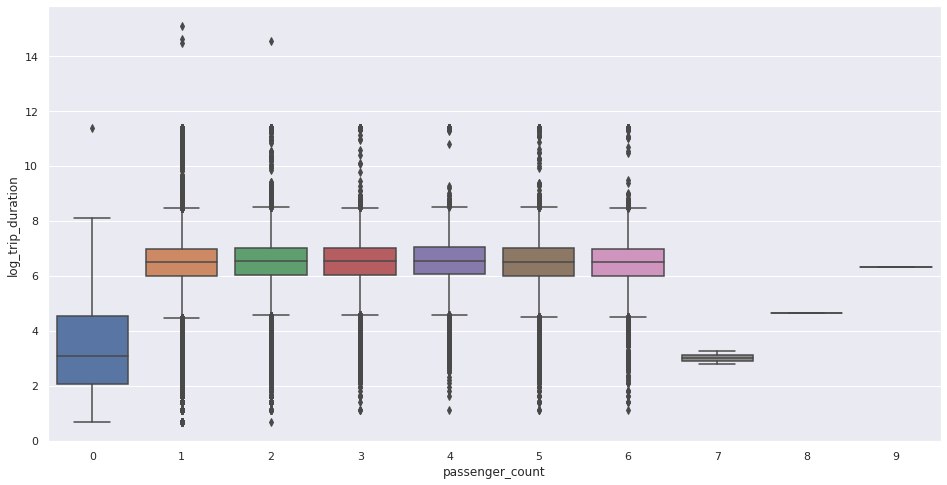

In [126]:
sns.boxplot(data=df, x='passenger_count', y='log_trip_duration')

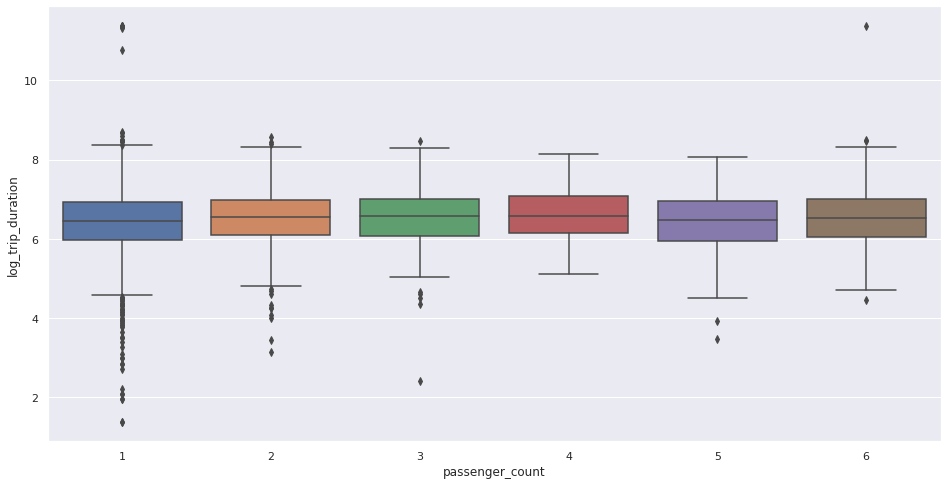

In [127]:
sns.boxplot(data=df.sample(5000), x='passenger_count', y='log_trip_duration')

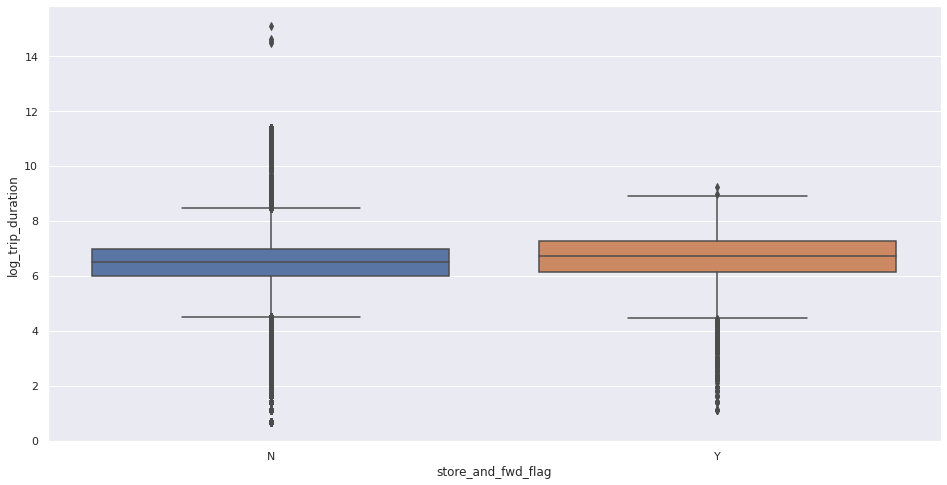

In [128]:
sns.boxplot(data=df, x='store_and_fwd_flag', y='log_trip_duration')

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [129]:
df.loc[df['vendor_id'] == 1, 'vendor_id'] = 0
df.loc[df['vendor_id'] == 2, 'vendor_id'] = 1
df.loc[df['store_and_fwd_flag'] == 'N', 'store_and_fwd_flag'] = 0
df.loc[df['store_and_fwd_flag'] == 'Y', 'store_and_fwd_flag'] = 1

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

На барплоте по неполной выбороке зависимость от количества пассажиров видна более явно, так что думаю, что признак passenger_count немного улучшит модель. Признак store_and_fwd_flag при значении 'Y' в среднем увеличивает продолжительность поездки. Признак vendor_id особо на длительность не влияет.

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [130]:
categorical = ['weekday', 'hour', 'month', 'number_of_day', 'pickup_city_zone', 'dropoff_city_zone', 'is_jam', 'is_blizzard', 'is_heat', 'pickup_at_jfk', 'dropoff_at_jfk', 'dropoff_at_lga', 'pickup_at_lga', 'vendor_id', 'store_and_fwd_flag']
numeric_features = ['log_haversine', 'passenger_count']

X_train, X_test, y_train, y_test = train_test_split(df, df['log_trip_duration'], test_size=0.3, random_state=10)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4723


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

Они дали прирост в 0.0002, так что выкидываем

In [131]:
df = df.drop(columns=['vendor_id', 'store_and_fwd_flag', 'passenger_count'])

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты: с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите обучающую выборку от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


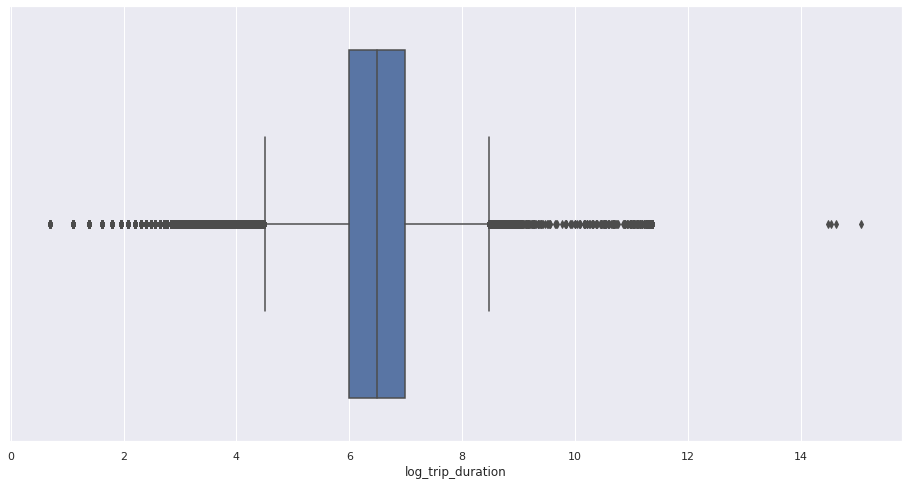

In [132]:
sns.boxplot(X_train['log_trip_duration'])

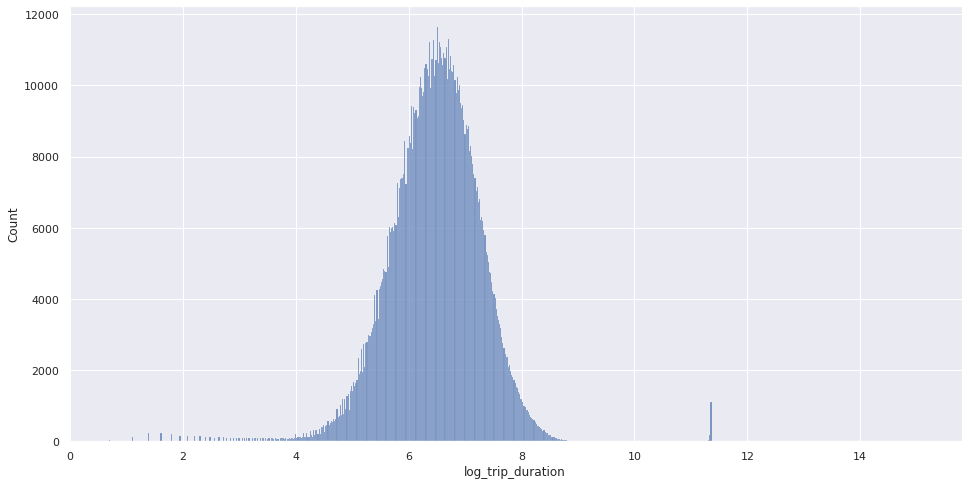

In [133]:
sns.histplot(X_train['log_trip_duration'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


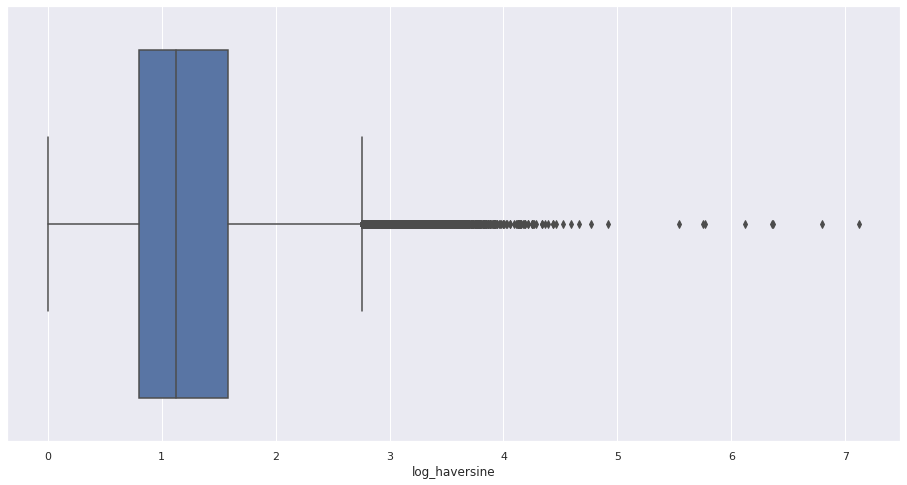

In [134]:
sns.boxplot(X_train['log_haversine'])

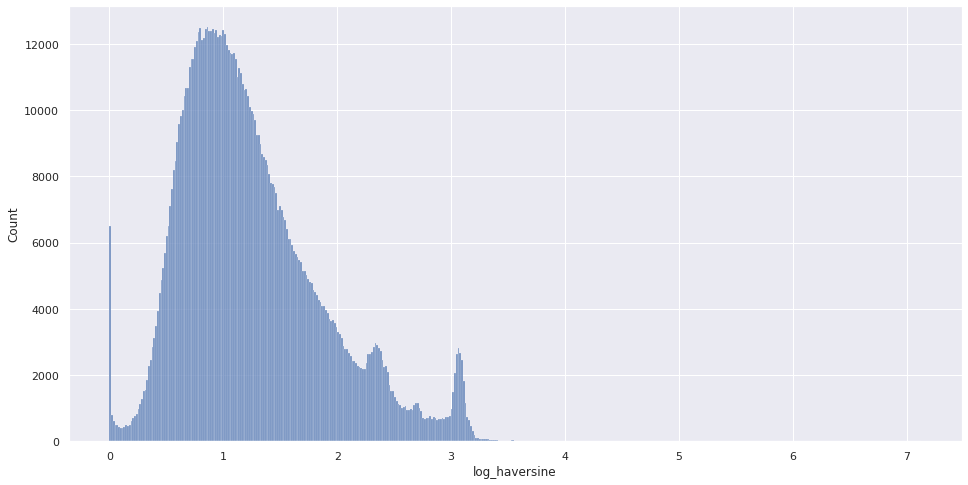

In [135]:
sns.histplot(X_train['log_haversine'])

In [136]:
X_train['predicted_dur'] = model.predict(X_train)
X_train['reg_residual'] = X_train['predicted_dur'] - X_train['log_trip_duration']

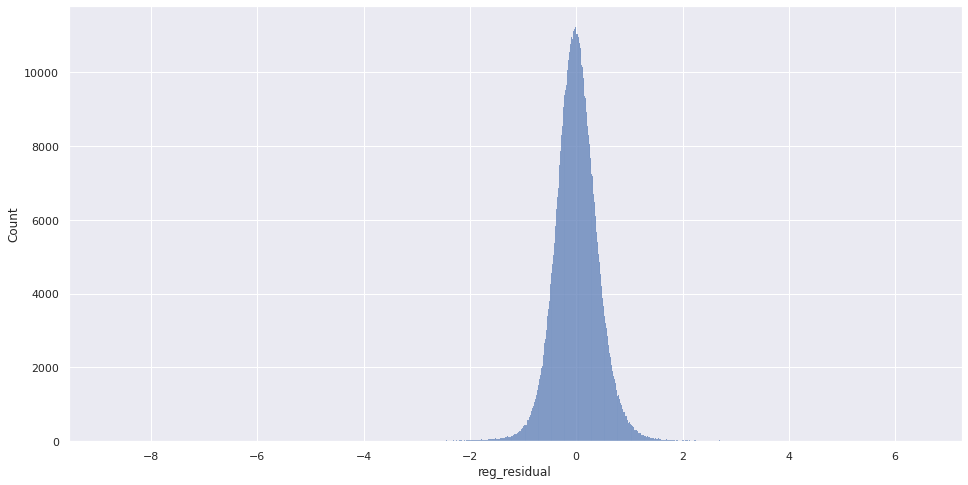

In [137]:
sns.histplot(X_train['reg_residual'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


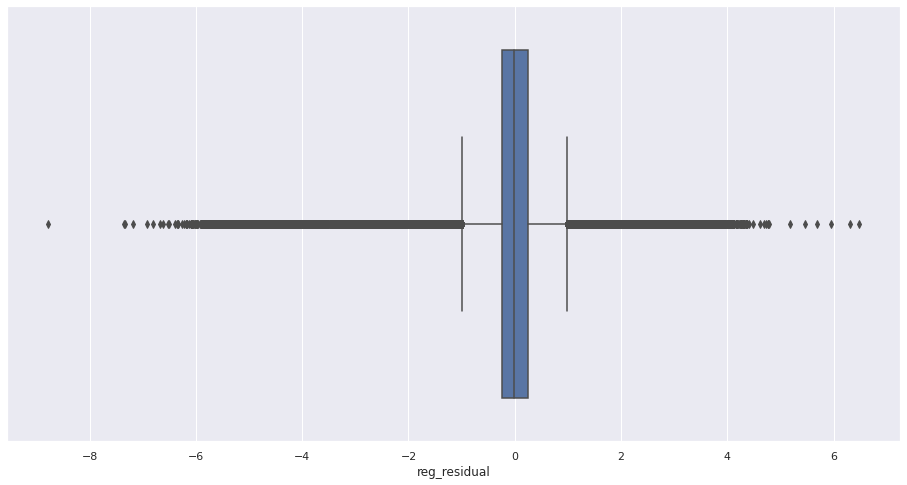

In [138]:
sns.boxplot(X_train['reg_residual'])

In [139]:
X_train.drop(X_train[(X_train['log_trip_duration'] >= 8.5) | (X_train['log_trip_duration'] <= 4)].index, inplace=True)
X_train.drop(X_train[(X_train['reg_residual'] >= 1) | (X_train['reg_residual'] <= -1)].index, inplace=True)
X_train.drop(X_train[(X_train['log_haversine'] >= 2.75) | (X_train['log_haversine'] == 0)].index, inplace=True)

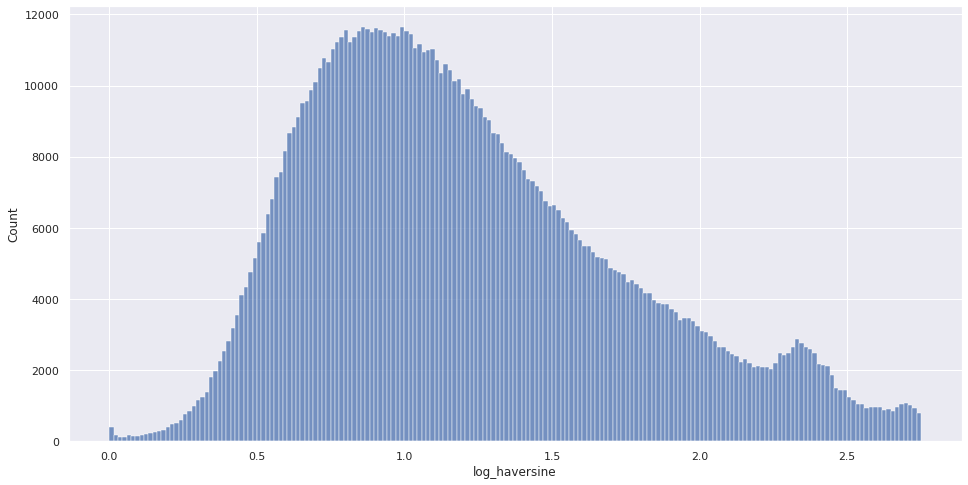

In [140]:
sns.histplot(X_train['log_haversine'])

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Попробуйте объединить редкие категории в одну. Естественно, делать это нужно только для действительно редких категорий.

In [141]:
df['abnormal_weather'] = df['is_blizzard'] | df['is_heat']
X_train['abnormal_weather'] = X_train['is_blizzard'] | X_train['is_heat']
X_test['abnormal_weather'] = X_test['is_blizzard'] | X_test['is_heat']

In [142]:
# эти признаки оказались хуже чем следующие
df['pickup_at_aeroport'] = df['pickup_at_jfk'] | df['pickup_at_lga']
X_train['pickup_at_aeroport'] = X_train['pickup_at_jfk'] | X_train['pickup_at_lga']
X_test['pickup_at_aeroport'] = X_test['pickup_at_jfk'] | X_test['pickup_at_lga']

df['dropoff_at_aeroport'] = df['dropoff_at_jfk'] | df['dropoff_at_lga']
X_train['dropoff_at_aeroport'] = X_train['dropoff_at_jfk'] | X_train['dropoff_at_lga']
X_test['dropoff_at_aeroport'] = X_test['dropoff_at_jfk'] | X_test['dropoff_at_lga']

In [143]:
df['aero_lga'] = df['dropoff_at_lga'] | df['pickup_at_lga']
X_train['aero_lga'] = X_train['dropoff_at_lga'] | X_train['pickup_at_lga']
X_test['aero_lga'] = X_test['dropoff_at_lga'] | X_test['pickup_at_lga']

df['aero_jfk'] = df['dropoff_at_jfk'] | df['pickup_at_jfk']
X_train['aero_jfk'] = X_train['dropoff_at_jfk'] | X_train['pickup_at_jfk']
X_test['aero_jfk'] = X_test['dropoff_at_jfk'] | X_test['pickup_at_jfk']

In [144]:
categorical = ['weekday', 'hour', 'number_of_day', 'pickup_city_zone', 'dropoff_city_zone', 'is_jam', 'aero_jfk', 'aero_lga']
numeric_features = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.4748


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [145]:
print("Size before OneHot:", X_train.shape)
print("Size after OneHot:", column_transformer.transform(X_train).shape)

Size before OneHot: (958727, 35)
Size after OneHot: (958727, 246)


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [146]:
from sklearn.linear_model import Lasso
categorical = ['weekday', 'hour', 'number_of_day', 'pickup_city_zone', 'dropoff_city_zone', 'is_jam', 'aero_jfk', 'aero_lga']
numeric_features = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso())
])

model = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))

Test RMSE = 0.7947


Сильно хуже чем Ridge регрессия, если не подбирать параметры регуляризации

Разбейте обучающую выборку на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [147]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

In [148]:
from sklearn.model_selection import GridSearchCV

alphas_lasso = np.logspace(-5, 1, 10)

cv = GridSearchCV(
    estimator=Lasso(),
    param_grid={"alpha": alphas_lasso},
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('cross_validation', cv)
])

model = pipeline.fit(X_train, X_train['log_trip_duration'])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1081.8385451218783, tolerance: 43.30753949365511
  positive,


Best alpha for Lasso = 0.00001


Text(0, 0.5, 'CV score Lasso')

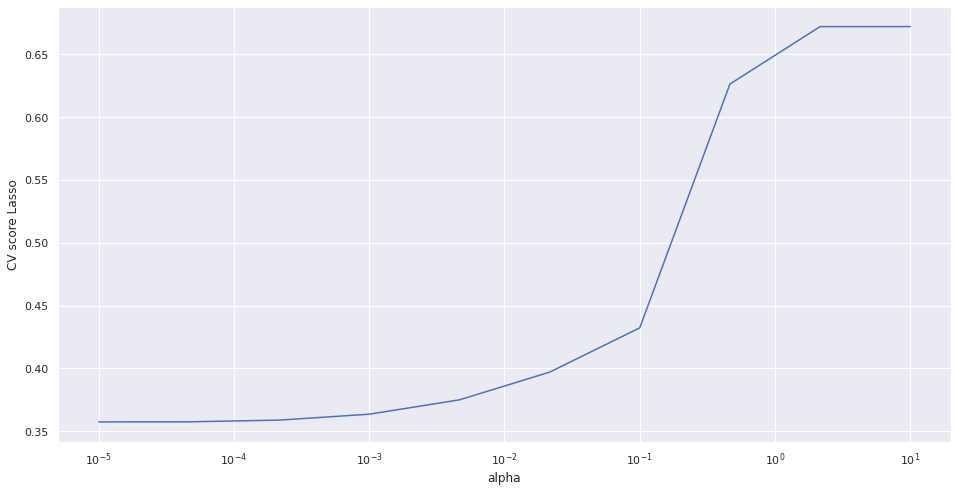

In [149]:
best_alpha_lasso = cv.best_params_["alpha"]
print("Best alpha for Lasso = %.5f" % best_alpha_lasso)
plt.plot(alphas_lasso, -cv.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score Lasso")

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best alpha for Ridge = 37.2759


Text(0, 0.5, 'CV score Ridge')

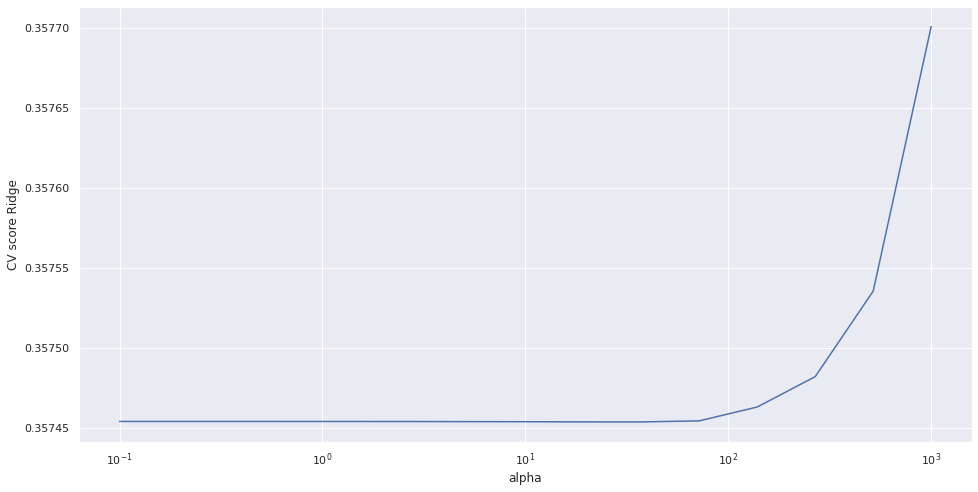

In [150]:
alphas_ridge = np.logspace(-1, 3, 15)

cv = GridSearchCV(
    estimator=Ridge(),
    param_grid={"alpha": alphas_ridge},
    scoring="neg_root_mean_squared_error",
    cv=5,
    n_jobs=-1,
    verbose=1)

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('cross_validation', cv)
])

model = pipeline.fit(X_train, X_train['log_trip_duration'])

best_alpha_ridge = cv.best_params_["alpha"]
print("Best alpha for Ridge = %.4f" % best_alpha_ridge)

plt.plot(alphas_ridge, -cv.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score Ridge")

In [151]:
pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print("Ridge Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))

Ridge Test RMSE = 0.4748


In [152]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(best_alpha_lasso))
])

model = lasso_pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print("Lasso Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1081.8385451218783, tolerance: 43.30753949365511
  positive,


Lasso Test RMSE = 0.4750


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [155]:
def get_zero_weights(alpha):
  lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alpha))
  ])
  model = lasso_pipeline.fit(X_train, X_train['log_trip_duration'])
  return np.sum(lasso_pipeline.steps[-1][-1].coef_ == 0)

In [157]:
alphas_lasso = np.logspace(-5, 1, 10)
zero_weight_q = []
for alpha in alphas_lasso:
  zero_weight_q.append(get_zero_weights(alpha))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1081.8385451218783, tolerance: 43.30753949365511
  positive,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78.56050830191816, tolerance: 43.30753949365511
  positive,


[18, 38, 114, 200, 226, 242, 245, 245, 246, 246]


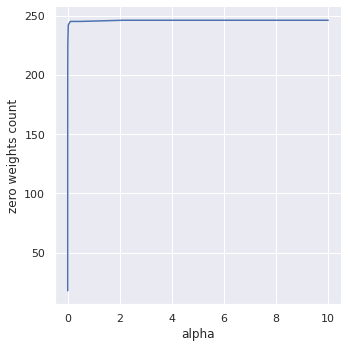

In [158]:
print(zero_weight_q)
sns.relplot(x=alphas_lasso, y=zero_weight_q, kind='line').set(xlabel='alpha', ylabel='zero weights count')

Как мы увидели выше, после кодирования всего признаков у нас 246, то есть мы хотим максимум 123 признака.

In [159]:
needed_alpha = alphas_lasso[zero_weight_q.index(200)]

In [160]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(needed_alpha))
])

model = lasso_pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print(f"Чтобы избавиться хотя бы от половины признаков берем alpha={needed_alpha}, тогда:")
print("RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))

Чтобы избавиться хотя бы от половины признаков берем alpha=0.001, тогда:
RMSE = 0.4835


In [161]:
lasso_pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Lasso(alphas_lasso[0]))
])

model = lasso_pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print(f"Если берем alpha={alphas_lasso[0]}, тогда:")
print("RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:622: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1081.8385451218783, tolerance: 43.30753949365511
  positive,


Если берем alpha=1e-05, тогда:
RMSE = 0.4750


То есть мы теряем 0.0085 в точности

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

Потому что для нее эти признаки независимые, а мы даем ей классификацию

In [162]:
mask = ((X_train['pickup_city_zone'] != -1) & (X_train['dropoff_city_zone'] != -1))
gk = X_train[mask].groupby(['pickup_city_zone', 'dropoff_city_zone']).agg('size').reset_index().rename(columns={0: 'quantity'}).sort_values('quantity', ascending=False).reset_index(drop=True).loc[:99]

In [163]:
def get_journey(journey, X):
  return ((X['pickup_city_zone'] == journey['pickup_city_zone']) & (X['dropoff_city_zone'] == journey['dropoff_city_zone']))

X_train['zone_journey'] = -1
X_test['zone_journey'] = -1

for zone, journey in gk.iterrows():
  X_train.loc[get_journey(journey, X_train), 'zone_journey'] = zone
  X_test.loc[get_journey(journey, X_test), 'zone_journey'] = zone

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [164]:
categorical = ['weekday', 'hour', 'month', 'number_of_day', 'pickup_city_zone', 'dropoff_city_zone', 'is_jam', 'aero_jfk', 'aero_lga', 'zone_journey']
numeric_features = ['log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge(best_alpha_ridge))
])

model = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.4655


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут). 

Оно улучшит нахождение расстояния между точкой посадки и высадки в большинстве поездок (так как улицы в нью йорке параллельные)

In [165]:
from numpy.linalg import norm

x_axis = np.array([[40.759444232836046, -73.96557837600751], [40.77029390390388, -73.99135080740905]])
y_axis = np.array([[40.75462354214995, -73.97585691057512], [40.786486421993466, -73.95261433132089]])

def cross(a, b):
    return a[0] * b[1] - b[0] * a[1]

def manh(x1, y1, x2, y2):
    return np.abs(x2 - x1) + np.abs(y2 - y1)

def get_y(x, y):
    tmp = np.array((x_axis[0][0] - x, x_axis[0][1] - y))
    n = cross(x_axis[1] - x_axis[0], tmp) / norm(x_axis[1] - x_axis[0])
    return n
  
def get_x(x, y):
    tmp = np.array((y_axis[0][0] - x, y_axis[0][1] - y))
    n = cross(y_axis[1] - y_axis[0], tmp) / norm(y_axis[1] - y_axis[0])
    return n
  
SCALE = 275 # подобрал так, чтобы максимизировать корреляцию и качество модели

def manhattan(lat1, lng1, lat2, lng2):
    x1 = get_x(lat1, lng1) * SCALE
    y1 = get_y(lat1, lng1) * SCALE
    x2 = get_x(lat2, lng2) * SCALE
    y2 = get_y(lat2, lng2) * SCALE
    return manh(x1, y1, x2, y2)

X_train['manhattan'] = manhattan(X_train['pickup_latitude'], X_train['pickup_longitude'], X_train['dropoff_latitude'], X_train['dropoff_longitude'])
X_test['manhattan'] = manhattan(X_test['pickup_latitude'], X_test['pickup_longitude'], X_test['dropoff_latitude'], X_test['dropoff_longitude'])
X_train['log_manhattan'] = np.log1p(X_train['manhattan'])
X_test['log_manhattan'] = np.log1p(X_test['manhattan'])

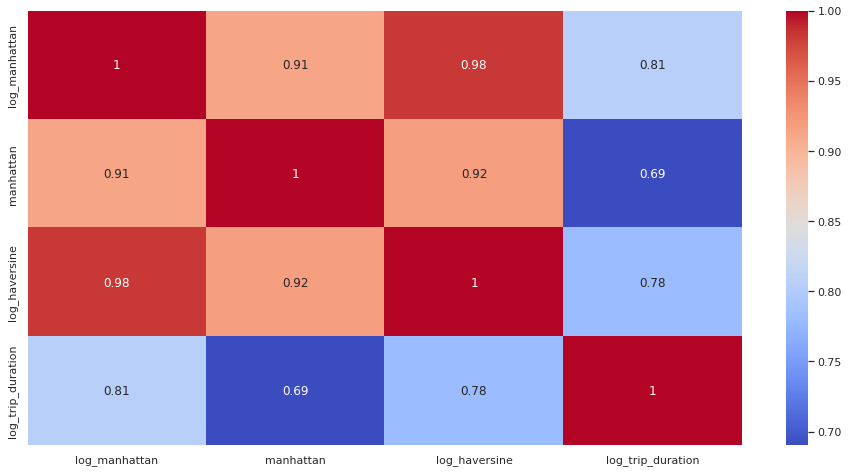

In [166]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(X_train[['log_manhattan', 'manhattan', 'log_haversine', 'log_trip_duration']].corr(), annot=True, fmt='.2g', cmap='coolwarm')

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [167]:
categorical = ['weekday', 'hour', 'month', 'number_of_day', 'pickup_city_zone', 'dropoff_city_zone', 'is_jam', 'aero_jfk', 'aero_lga', 'zone_journey']
numeric_features = ['log_manhattan']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.4422


Стало лучше, так как в городе Нью-Йорк расстояние большей части поездок с высокой точностью оценичвается Манхеттенским расстоянием (улицы и авеню строят сетку), а haversine расстояние по сути считает, что машины умеют летать. Поэтому так как большая часть датасета эот поездки на Манхеттене, то качество модоели удалось улучшить. Ну и сразу видим, что корреляция log_manhetten с длиттельностью поездки выше чем у log_haversine

In [168]:
m = folium.Map(location=center_location, zoom_start=12)
folium.PolyLine(x_axis, color="blue", weight=2.5, opacity=1).add_to(m)
folium.PolyLine(y_axis, color="blue", weight=2.5, opacity=1).add_to(m)
m

![image](map.png)

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [169]:
!pip install h3
!pip install h3pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [170]:
def visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium.Map(location=[sum(lat)/len(lat), sum(lng)/len(lng)], zoom_start=13, tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=8,color=color)
        m.add_child(my_PolyLine)
    return m

In [378]:
from sklearn.base import BaseEstimator, TransformerMixin

class MapGridHexTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, pop_drop_hexes1, pop_pick_hexes1, pop_drop_hexes2, pop_pick_hexes2):
        self.pop_drop_hexes1 = pop_drop_hexes1
        self.pop_pick_hexes1 = pop_pick_hexes1
        self.pop_drop_hexes2 = pop_drop_hexes2
        self.pop_pick_hexes2 = pop_pick_hexes2
        pass
    
    def fit(self, X=None, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        # pickup
        X_renamed = X[['pickup_longitude', 'pickup_latitude']].rename({'pickup_longitude': 'lng', 'pickup_latitude': 'lat'}, axis=1)

        X['pickup_hex_zone1'] = X_renamed.h3.geo_to_h3(HEX_SCALE1).index
        X.loc[~X['pickup_hex_zone1'].isin(self.pop_pick_hexes1), 'pickup_hex_zone1'] = '-'

        X['pickup_hex_zone2'] = X_renamed.h3.geo_to_h3(HEX_SCALE2).index
        X.loc[~X['pickup_hex_zone2'].isin(self.pop_pick_hexes2), 'pickup_hex_zone2'] = '-'
      
        # dropoff
        X_renamed = X[['dropoff_longitude', 'dropoff_latitude']].rename({'dropoff_longitude': 'lng', 'dropoff_latitude': 'lat'}, axis=1)

        X['dropoff_hex_zone1'] = X_renamed.h3.geo_to_h3(HEX_SCALE1).index
        X.loc[~X['dropoff_hex_zone1'].isin(self.pop_drop_hexes1), 'dropoff_hex_zone1'] = '-'
      
        X['dropoff_hex_zone2'] = X_renamed.h3.geo_to_h3(HEX_SCALE2).index
        X.loc[~X['dropoff_hex_zone2'].isin(self.pop_drop_hexes2), 'dropoff_hex_zone2'] = '-'
        return X

In [387]:
from h3 import h3
import h3pandas

HEX_SCALE1 = 10
SCALE_CODE1 = '10'
HEX_Q1 = 3000

pop_drop_hexes1 = X_train[['dropoff_longitude', 'dropoff_latitude']].rename({'dropoff_longitude': 'lng', 'dropoff_latitude': 'lat'}, axis=1).h3.geo_to_h3(HEX_SCALE1).reset_index()[f'h3_{SCALE_CODE1}'].value_counts()[:HEX_Q1].index.tolist()
pop_pick_hexes1 = X_train[['pickup_longitude', 'pickup_latitude']].rename({'pickup_longitude': 'lng', 'pickup_latitude': 'lat'}, axis=1).h3.geo_to_h3(HEX_SCALE1).reset_index()[f'h3_{SCALE_CODE1}'].value_counts()[:HEX_Q1].index.tolist()

HEX_SCALE2 = 8
SCALE_CODE2 = '08'
HEX_Q2 = 50

pop_drop_hexes2 = X_train[['dropoff_longitude', 'dropoff_latitude']].rename({'dropoff_longitude': 'lng', 'dropoff_latitude': 'lat'}, axis=1).h3.geo_to_h3(HEX_SCALE2).reset_index()[f'h3_{SCALE_CODE2}'].value_counts()[:HEX_Q2].index.tolist()
pop_pick_hexes2 = X_train[['pickup_longitude', 'pickup_latitude']].rename({'pickup_longitude': 'lng', 'pickup_latitude': 'lat'}, axis=1).h3.geo_to_h3(HEX_SCALE2).reset_index()[f'h3_{SCALE_CODE2}'].value_counts()[:HEX_Q2].index.tolist()

In [388]:
map_hex_transformer = MapGridHexTransformer(pop_drop_hexes1, pop_pick_hexes1, pop_drop_hexes2, pop_pick_hexes2)
X_train = map_hex_transformer.transform(X_train)
X_test = map_hex_transformer.transform(X_test)

In [393]:
PATH_Q = 400

mask = ((X_train['pickup_hex_zone2'] != '-') & (X_train['dropoff_hex_zone2'] != '-'))
gk = X_train[mask].groupby(['pickup_hex_zone2', 'dropoff_hex_zone2']).agg('size').reset_index().rename(columns={0: 'quantity'}).sort_values('quantity', ascending=False).reset_index(drop=True).loc[:PATH_Q]

def get_hex_journey(journey, X):
  return ((X['pickup_hex_zone2'] == journey['pickup_hex_zone2']) & (X['dropoff_hex_zone2'] == journey['dropoff_hex_zone2']))

X_train['hex_zone_journey'] = -1
X_test['hex_zone_journey'] = -1

for zone, journey in gk.iterrows():
  X_train.loc[get_hex_journey(journey, X_train), 'hex_zone_journey'] = zone
  X_test.loc[get_hex_journey(journey, X_test), 'hex_zone_journey'] = zone

In [394]:
categorical = ['weekday', 'hour', 'month', 'number_of_day', 'pickup_city_zone', 'dropoff_city_zone', 'pickup_hex_zone1', 'dropoff_hex_zone1', 'aero_jfk', 'aero_lga', 'is_jam', 'zone_journey', 'hex_zone_journey']
numeric_features = ['log_manhattan', 'log_haversine']

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(), categorical),
    ('scaling', StandardScaler(), numeric_features)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, X_train['log_trip_duration'])
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(X_test['log_trip_duration'], y_pred, squared=False))

Test RMSE = 0.4292


**Таким образом улучшил точность модели на 0.013**

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

![gif](giphy.gif)